In [1]:
import numpy as np
import matplotlib.pyplot as plt
import io
import SurfaceTopography.Uniform.GeometryAnalysis as CAA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy import interpolate
import plotly.express as px

In [2]:
from ContactMechanics import PeriodicFFTElasticHalfSpace, FreeFFTElasticHalfSpace
from SurfaceTopography import Topography
from SurfaceTopography import make_sphere
from ContactMechanics.Factory import make_system
from ContactMechanics.Systems import NonSmoothContactSystem
from ContactMechanics.Tools.Logger import screen

In [3]:
sx,sy= 4.8,4.8

In [4]:
Es =  1/np.pi #MPa
nu = 0.25
R = 1

In [5]:
nx, ny = 4096,4096

In [ ]:
sphere = make_sphere(R, (nx, nx), (sx, sy),
        centre=(sx / 2, sy / 2), kind="paraboloid", )

x, y = sphere.positions()
x -= sx / 2
y -= sy /2
radius = np.sqrt(x ** 2 + y ** 2)

theta_out = np.zeros((nx,ny))
#theta = np.arctan(y/x, out = theta_out, where = x!=0 )
theta = np.arctan2(y,x)
#h_m = 1/np.pi
substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
#r = np.sqrt((x*x)+(y*y))
#h_m = r*r/(2*R)
topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
amplitude = 0.004
radial_waves = Topography(amplitude*(np.cos(64*theta)), physical_sizes=(sx,sy))
topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))

system1 = make_system(substrate, topography1)
system2 = make_system(substrate, topography)
gtol = 1e-6
penetration = 1.2
sol1 = system1.minimize_proxy(
    #initial_displacements=u_initial_guess,
    #logger=Logger("evaluations.log"),
    #logger=screen,
    offset=penetration,
)
sol2 = system2.minimize_proxy(
    #initial_displacements=u_initial_guess,
    #logger=Logger("evaluations.log"),
    #logger=screen,
    offset=penetration,
)
u = system1.displacements = sol1.x
gap = system1.compute_gap(u, penetration)

force = - system1.substrate.evaluate_force(u)
pressures = force[system1.substrate.local_topography_subdomain_slices] \
            / system1.surface.area_per_pt
contact_area = np.where(pressures>0)
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

    def inverse(self, value):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        return np.interp(value, [normalized_min, normalized_mid,
                                 normalized_max], [self.vmin, self.midpoint, self.vmax])
#pressurecmap = LinearSegmentedColormap.from_list('testCmap', (
    #(0.15294117647058825, 0.39215686274509803, 0.09803921568627451, 1.),
    #(1, 1, 1, 0.),
    #(0.5568627450980392, 0.00392156862745098, 0.3215686274509804, 1)), N=256)
pressurecmap = LinearSegmentedColormap.from_list('testCmap', (
    (0.15294117647058825, 0.39215686274509803, 0.09803921568627451, 1.),
    (1, 1, 1, 0.),
    (0.5568627450980392, 0.00392156862745098, 0.3215686274509804, 1)), N=256)
fig, ax = plt.subplots()

plt.colorbar(ax.imshow(radial_waves.heights().T,
             cmap="coolwarm", extent=(-sx / 2, sx / 2, -sy / 2, sy / 2), rasterized=True),
             ax=ax, label=r"Heights $h^*$")
ax.imshow(pressures.T, cmap=pressurecmap, extent=(-sx / 2, sx / 2, -sy / 2, sy / 2), rasterized=True)


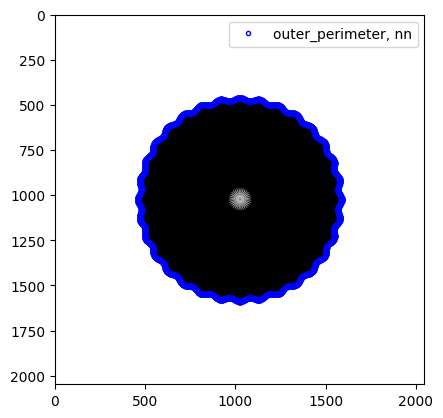

In [10]:
contact_area1 = system1.contact_zone
contact_area2 = system2.contact_zone
Nx, Ny = contact_area1.shape
x,y = np.mgrid[:Nx, :Ny]
    
fig, ax = plt.subplots()
ax.imshow(contact_area1, cmap="Greys")
#iper = CAA.inner_perimeter_area(contact_area, True, stencil=CAA.nn_stencil)
#ax.plot(x[iper], y[iper], ".r", label="inner_perimeter, nn")
    #iper = CAA.inner_perimeter_area(contacting_points, True, stencil=CAA.nnn_stencil)
    #ax.plot(x[iper], y[iper], "xr", label="inner_perimeter, nnn")
    
oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nn_stencil)
oper[1600:nx//2,1600:ny//2]=False 
oper[nx//2:1280, ny//2:1280] = False
oper[1600:nx//2, ny//2:1280] = False
oper[nx//2:1280,800:ny//2]=False
sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nn_stencil)
ax.plot(x[oper], y[oper], ".b", mfc="none",label="outer_perimeter, nn")
#ax.plot(x[sper], y[sper], ".r", mfc="none",label="outer_perimeter, nn")
#oper = CAA.outer_perimeter_area(contact_area, False, stencil=CAA.nnn_stencil)
#ax.plot(x[oper], y[oper], "+b", label="outer_perimeter, nnn")
ax.legend()


In [30]:
Sx = x[sper]
Sy = y[sper]
Smax = [np.max(Sx), np.max(Sy)]
print(Smax)

[198, 198]


In [31]:
X = x[oper]
Y = y[oper]
Omax = [np.max(X), np.max(Y)]
print(Omax)

[207, 207]


In [32]:
O_error = np.sqrt((Omax[0]-Smax[0])**2 + (Omax[1]-Smax[1])**2)
print(2*O_error)

25.45584412271571


In [33]:
center = [np.mean(X), np.mean(X)]

distances = []
for i in range(len(X)):
    distance = np.sqrt((X[i] - center[0])**2 + (Y[i] - center[1])**2)
    distances.append(distance)


In [34]:
min_distance = min(distances)
max_distance = max(distances)

In [35]:
print(center, min_distance, max_distance)

[128.0, 128.0] 55.86591089385369 79.1580697086532


0.04
0.042
0.044000000000000004
0.046
0.048
0.05


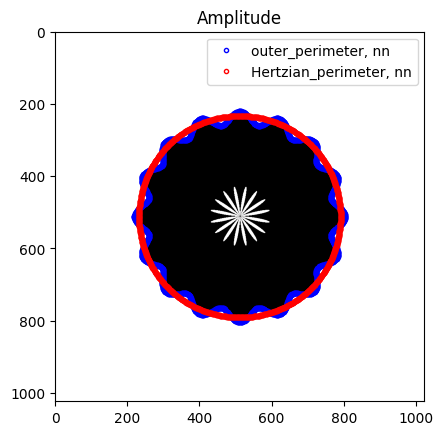

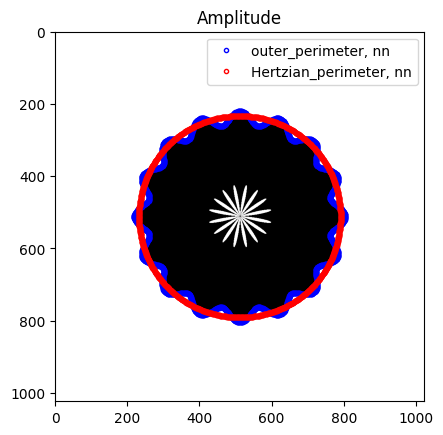

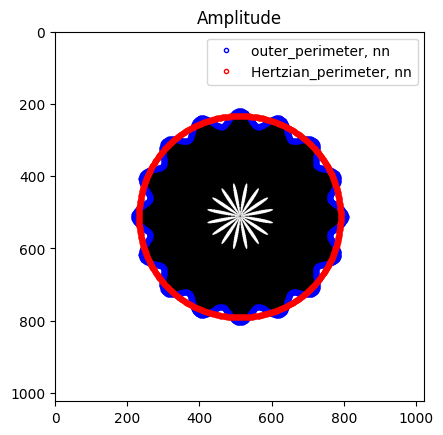

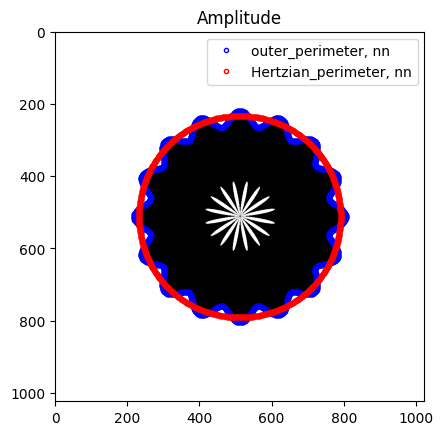

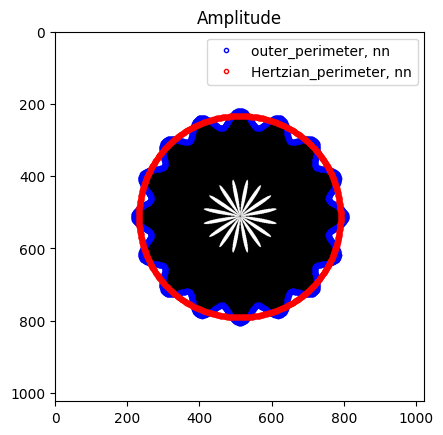

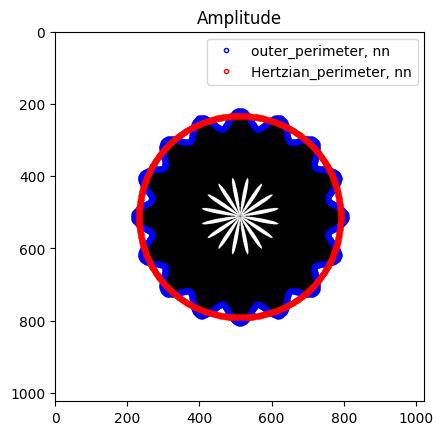

In [11]:
amplitudes = np.linspace(0.04,0.05,6)
for a in amplitudes:
    print(a)
    sphere = make_sphere(R, (nx, nx), (sx, sy),
        centre=(sx / 2, sy / 2), kind="paraboloid", )

    x, y = sphere.positions()
    x -= sx / 2
    y -= sy /2
    radius = np.sqrt(x ** 2 + y ** 2)

    #theta_out = np.zeros((nx,ny))
    #theta = np.arctan(y/x, out = theta_out, where = x!=0 )
    theta = np.arctan2(y,x)
    #h_m = 1/np.pi
    substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
    #r = np.sqrt((x*x)+(y*y))
    #h_m = r*r/(2*R)
    topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
    
    radial_waves = Topography(a*(np.cos(16*theta)), physical_sizes=(sx,sy))
    topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))

    system1 = make_system(substrate, topography1)
    system2 = make_system(substrate, topography)
    gtol = 1e-6
    penetration = 1.2
    
    sol1 = system1.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    sol2 = system2.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    u = system1.displacements = sol1.x
    gap = system1.compute_gap(u, penetration)

    force = - system1.substrate.evaluate_force(u)
    pressures = force[system1.substrate.local_topography_subdomain_slices] \
            / system1.surface.area_per_pt

    class MidpointNormalize(mpl.colors.Normalize):
        def __init__(self, vmin, vmax, midpoint=0, clip=False):
            self.midpoint = midpoint
            mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
            normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
            normalized_mid = 0.5
            x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
            return sp.ma.masked_array(sp.interp(value, x, y))

        def inverse(self, value):
            normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
            normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
            normalized_mid = 0.5
            return np.interp(value, [normalized_min, normalized_mid,
                                 normalized_max], [self.vmin, self.midpoint, self.vmax])
    
    contact_area1 = system1.contact_zone
    contact_area2 = system2.contact_zone
    Nx, Ny = contact_area1.shape
    x,y = np.mgrid[:Nx, :Ny]
    
    
    #iper = CAA.inner_perimeter_area(contact_area, True, stencil=CAA.nn_stencil)
    #ax.plot(x[iper], y[iper], ".r", label="inner_perimeter, nn")
    #iper = CAA.inner_perimeter_area(contacting_points, True, stencil=CAA.nnn_stencil)
    #ax.plot(x[iper], y[iper], "xr", label="inner_perimeter, nnn")
    
    oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nn_stencil)
    oper[400:nx//2,400:ny//2]=False 
    oper[nx//2:640, ny//2:640] = False
    oper[400:nx//2, ny//2:640] = False
    oper[nx//2:640,400:ny//2]=False
    sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nn_stencil)
    
    
    
    X = x[oper]
    Y = y[oper]
    center = [np.mean(X), np.mean(X)]
    
    distances = []
    for i in range(len(X)):
        distance = np.sqrt((X[i] - center[0])**2 + (Y[i] - center[1])**2)
        distances.append(distance)
    min_distance = min(distances)
    max_distance = max(distances)
    
    fig, ax = plt.subplots()
    ax.set_title("Amplitude")
    ax.imshow(contact_area1, cmap="Greys")
    ax.plot(x[oper], y[oper], ".b", mfc="none",label="outer_perimeter, nn")
    ax.plot(x[sper], y[sper], ".r", mfc="none",label="Hertzian_perimeter, nn")
    
    
    #oper = CAA.outer_perimeter_area(contact_area, False, stencil=CAA.nnn_stencil)
    #ax.plot(x[oper], y[oper], "+b", label="outer_perimeter, nnn")
    ax.legend()
    
    
    
    

0.04
0.042
0.044000000000000004
0.046
0.048
0.05


(0.0, 50.0)

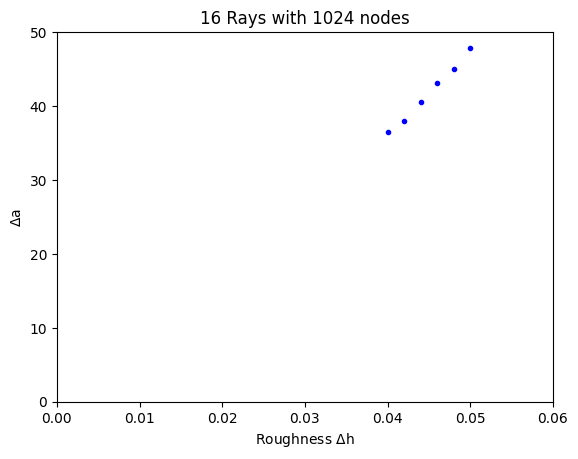

In [16]:
amplitudes = np.linspace(0.04,0.05,6)
for a in amplitudes:
    print(a)
    sphere = make_sphere(R, (nx, nx), (sx, sy),
        centre=(sx / 2, sy / 2), kind="paraboloid", )

    x, y = sphere.positions()
    x -= sx / 2
    y -= sy /2
    radius = np.sqrt(x ** 2 + y ** 2)

    #theta_out = np.zeros((nx,ny))
    #theta = np.arctan(y/x, out = theta_out, where = x!=0 )
    theta = np.arctan2(y,x)
    #h_m = 1/np.pi
    substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
    #r = np.sqrt((x*x)+(y*y))
    #h_m = r*r/(2*R)
    topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
    
    radial_waves = Topography(a*(np.cos(16*theta)), physical_sizes=(sx,sy))
    topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))

    system1 = make_system(substrate, topography1)
    system2 = make_system(substrate, topography)
    gtol = 1e-6
    penetration = 1.2
    
    sol1 = system1.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    sol2 = system2.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    u = system1.displacements = sol1.x
    gap = system1.compute_gap(u, penetration)

    force = - system1.substrate.evaluate_force(u)
    pressures = force[system1.substrate.local_topography_subdomain_slices] \
            / system1.surface.area_per_pt

    class MidpointNormalize(mpl.colors.Normalize):
        def __init__(self, vmin, vmax, midpoint=0, clip=False):
            self.midpoint = midpoint
            mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
            normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
            normalized_mid = 0.5
            x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
            return sp.ma.masked_array(sp.interp(value, x, y))

        def inverse(self, value):
            normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
            normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
            normalized_mid = 0.5
            return np.interp(value, [normalized_min, normalized_mid,
                                 normalized_max], [self.vmin, self.midpoint, self.vmax])
    
    contact_area1 = system1.contact_zone
    contact_area2 = system2.contact_zone
    Nx, Ny = contact_area1.shape
    x,y = np.mgrid[:Nx, :Ny]
    
    
    #iper = CAA.inner_perimeter_area(contact_area, True, stencil=CAA.nn_stencil)
    #ax.plot(x[iper], y[iper], ".r", label="inner_perimeter, nn")
    #iper = CAA.inner_perimeter_area(contacting_points, True, stencil=CAA.nnn_stencil)
    #ax.plot(x[iper], y[iper], "xr", label="inner_perimeter, nnn")
    
    oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nn_stencil)
    oper[400:nx//2,400:ny//2]=False 
    oper[nx//2:640, ny//2:640] = False
    oper[400:nx//2, ny//2:640] = False
    oper[nx//2:640,400:ny//2]=False
    sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nn_stencil)
    
    
    
    X = x[oper]
    Y = y[oper]
    center = [np.mean(X), np.mean(X)]
    
    distances = []
    for i in range(len(X)):
        distance = np.sqrt((X[i] - center[0])**2 + (Y[i] - center[1])**2)
        distances.append(distance)
    min_distance = min(distances)
    max_distance = max(distances)
    
    plt.plot(a, max_distance-min_distance,".b")
    
plt.title("16 Rays with 1024 nodes")    
plt.xlabel("Roughness $\Delta$h")
plt.ylabel("$\Delta$a")    
plt.xlim(0,0.06)   
plt.ylim(0,50)
    
    
   
   
    
    
    
    

0.0
1.9321597710948026
0.01
9.13367324903129
0.02
17.474326141192023
0.03
26.65121203241324
0.04
36.53772968226809
0.05
47.90570511237996


(0.0, 50.0)

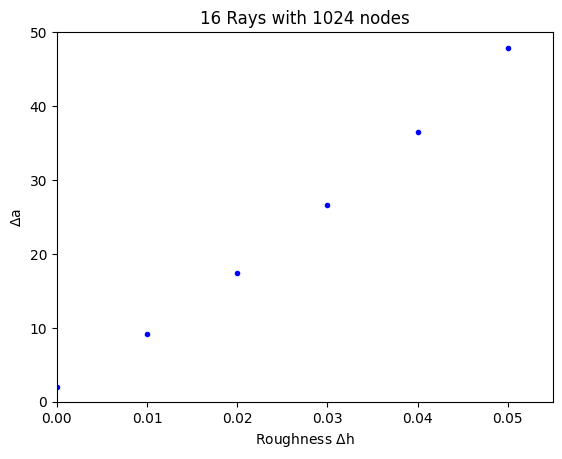

In [22]:
amplitudes = np.linspace(0,0.05,6)
for a in amplitudes:
    print(a)
    sphere = make_sphere(R, (nx, nx), (sx, sy),
        centre=(sx / 2, sy / 2), kind="paraboloid", )

    x, y = sphere.positions()
    x -= sx / 2
    y -= sy /2
    radius = np.sqrt(x ** 2 + y ** 2)

    #theta_out = np.zeros((nx,ny))
    #theta = np.arctan(y/x, out = theta_out, where = x!=0 )
    theta = np.arctan2(y,x)
    #h_m = 1/np.pi
    substrate = PeriodicFFTElasticHalfSpace(nb_grid_pts=(nx,ny), young=Es, physical_sizes = (sx, sy))
    #r = np.sqrt((x*x)+(y*y))
    #h_m = r*r/(2*R)
    topography = make_sphere(R, (nx,ny), (sx,sy), 
                     nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
                    subdomain_locations=substrate.topography_subdomain_locations,centre=(sx/2, sy/2), kind="paraboloid")
    
    radial_waves = Topography(a*(np.cos(16*theta)), physical_sizes=(sx,sy))
    topography1 = Topography((topography.heights() + radial_waves.heights()), physical_sizes=(sx, sy))

    system1 = make_system(substrate, topography1)
    system2 = make_system(substrate, topography)
    gtol = 1e-6
    penetration = 1.2
    
    sol1 = system1.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    sol2 = system2.minimize_proxy(
        #initial_displacements=u_initial_guess,
        #logger=Logger("evaluations.log"),
        #logger=screen,
        offset=penetration,
    )
    u = system1.displacements = sol1.x
    gap = system1.compute_gap(u, penetration)

    force = - system1.substrate.evaluate_force(u)
    pressures = force[system1.substrate.local_topography_subdomain_slices] \
            / system1.surface.area_per_pt

    class MidpointNormalize(mpl.colors.Normalize):
        def __init__(self, vmin, vmax, midpoint=0, clip=False):
            self.midpoint = midpoint
            mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
            normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
            normalized_mid = 0.5
            x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
            return sp.ma.masked_array(sp.interp(value, x, y))

        def inverse(self, value):
            normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
            normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
            normalized_mid = 0.5
            return np.interp(value, [normalized_min, normalized_mid,
                                 normalized_max], [self.vmin, self.midpoint, self.vmax])
    
    contact_area1 = system1.contact_zone
    contact_area2 = system2.contact_zone
    Nx, Ny = contact_area1.shape
    x,y = np.mgrid[:Nx, :Ny]
    
    
    #iper = CAA.inner_perimeter_area(contact_area, True, stencil=CAA.nn_stencil)
    #ax.plot(x[iper], y[iper], ".r", label="inner_perimeter, nn")
    #iper = CAA.inner_perimeter_area(contacting_points, True, stencil=CAA.nnn_stencil)
    #ax.plot(x[iper], y[iper], "xr", label="inner_perimeter, nnn")
    
    oper = CAA.outer_perimeter_area(contact_area1, False, stencil=CAA.nn_stencil)
    oper[400:nx//2,400:ny//2]=False 
    oper[nx//2:640, ny//2:640] = False
    oper[400:nx//2, ny//2:640] = False
    oper[nx//2:640,400:ny//2]=False
    sper = CAA.outer_perimeter_area(contact_area2, False, stencil=CAA.nn_stencil)
    
    
    
    X = x[oper]
    Y = y[oper]
    center = [np.mean(X), np.mean(X)]
    
    distances = []
    for i in range(len(X)):
        distance = np.sqrt((X[i] - center[0])**2 + (Y[i] - center[1])**2)
        distances.append(distance)
    min_distance = min(distances)
    max_distance = max(distances)
    
    plt.plot(a, max_distance-min_distance,".b")
    print(max_distance-min_distance)
plt.title("16 Rays with 1024 nodes")    
plt.xlabel("Roughness $\Delta$h")
plt.ylabel("$\Delta$a")    
plt.xlim(0,0.055)   
plt.ylim(0,50)
    
    
   
   
    
    
    
    

Text(0.5, 0, 'heights')

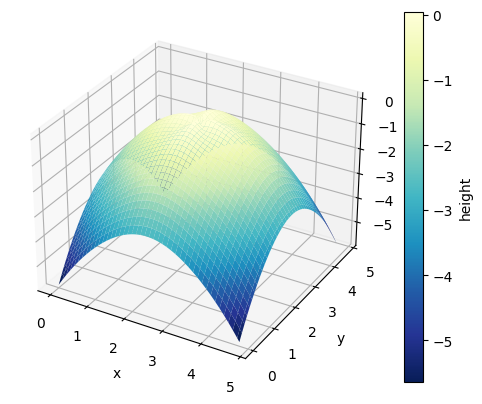

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = np.arange(0, nx, 1)*sx/nx
y = np.arange(0, ny, 1)*sy/ny
X,Y = np.meshgrid(x,y)

pcm = ax.plot_surface(X,Y,topography1.heights(), cmap=plt.cm.YlGnBu_r)
cb = plt.colorbar(pcm,ax= ax, label= "height")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("heights")